### Libraries

In [1]:
import os
from PIL import Image
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

import torch
import torchvision
import torch.nn.functional as F
import torchvision.transforms.v2 as v2
from torchvision.models import convnext_base
from collections import Counter
from torchvision.transforms import functional as TF
from scipy.ndimage import gaussian_filter, map_coordinates
from scipy.ndimage.interpolation import zoom
from torch import nn, optim
from efficientnet_pytorch import EfficientNet
from torchvision.transforms import transforms, Lambda
from torch.utils.data import random_split
import random
from torch.utils.data import DataLoader
import glob
from torchvision.transforms import ToPILImage
import torch
from torch.utils.data import Dataset
#!pip install git+https://github.com/facebookresearch/fvcore.git

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

/tmp/ipykernel_4031735/4231830264.py:18: DeprecationWarning: Please import `zoom` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.interpolation import zoom


In [2]:
pwd

'/home/shokoo/EchoView/view_classification/notebooks/models'

In [3]:
dataset_address = '/home/shokoo/EchoView/Datasets/data_split/'
files_address = '/home/shokoo/EchoView/view_classification'

In [4]:
paths = glob.glob(os.path.join(dataset_address + '**/*/*', '*')) #numebr of all samples per patients
len(paths)

665299

In [5]:
avg_data_mean = np.array([0.0847569 , 0.08113708, 0.08339239])
avg_data_std = np.array([0.17340048, 0.17009241, 0.17395345])

### Load the csv file containing the image file names and corresponding labels

In [6]:
info_train = pd.read_csv(os.path.join(files_address, 'csv_files/train_original.csv'))
info_val = pd.read_csv(os.path.join(files_address, 'csv_files/val_original.csv'))
info_test = pd.read_csv(os.path.join(files_address, 'csv_files/test_original.csv'))

In [7]:
len(info_train['label']), len(info_val['label']), len(info_test['label']), 

(4402, 1055, 1436)

In [8]:
print(Counter(info_train['label']))

Counter({'PLAX': 974, 'Apical-4ch': 771, 'Subcostal': 586, 'PSAX-ves': 481, 'Apical-2ch': 370, 'Apical-3ch': 366, 'Apical-5ch': 215, 'PSAX-mid': 197, 'PSAX-base': 176, 'Suprasternal': 147, 'PSAX-apical': 119})


In [9]:
def visualize_normalized(image, label, mean, std):
    # Un-normalize
    mean = torch.tensor(mean).view(3, 1, 1)
    std = torch.tensor(std).view(3, 1, 1)
    image = image * std + mean  # reverse normalization

    # Convert to [0, 1] and clamp to avoid display issues
    image = torch.clamp(image, 0, 1)

    # Convert to HWC
    image_np = image.permute(1, 2, 0).cpu().numpy()

    # Plot
    plt.figure(figsize=(8, 6))
    plt.imshow(image_np)
    plt.title(f"Label: {label.item()}")
    plt.axis('off')
    plt.show()


In [10]:
def visualization(image, label):
    plt.figure(figsize=(8, 6))
    
    if isinstance(image, torch.Tensor):
        if image.max() <= 1.0:
            image = image * 255.0  # Scale back to [0, 255] if needed
        image = image.byte().permute(1, 2, 0).cpu().numpy()
    
    plt.imshow(image)
    plt.title(f"Label: {label}")
    plt.xticks([])
    plt.yticks([])
    plt.show()

### Preprocessing

##### Define Transformers

In [11]:
class AddGaussianNoise(nn.Module):
    """Add Gaussian noise to a video."""
    def __init__(self, mean=0., std=1.):
        super().__init__()
        self.mean = mean
        self.std = std

    def forward(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean

to_pil = ToPILImage()
    
train_transform = nn.Sequential(
    # v2.RandomHorizontalFlip(p=0.2),
    # v2.RandomVerticalFlip(p=0.2),
    v2.RandomRotation(degrees=10),
    transforms.RandomApply([v2.ColorJitter(brightness=0.1, contrast=0.1)], p=0.2),
    transforms.RandomApply([torchvision.transforms.RandomAffine(degrees=0, translate=(0.05, 0.05), scale=(0.95, 1.05))], p=0.2),
    torchvision.transforms.RandomErasing(p=0.2),
    transforms.RandomApply([AddGaussianNoise(0., 0.1)], p= 0.2)
)

### Map images to their labels

In [12]:
class TTEDataset(torch.utils.data.Dataset):
    def __init__(self, csv_info, root_dir, data_mean=0.5, data_std=0.5,
                 use_npy=True, transform=None, remove_ecg=True, remove_static=True):
        self.meta = csv_info
        self.root_dir = root_dir
        self.data_mean = data_mean
        self.data_std = data_std
        self.use_npy = use_npy
        self.transform = transform
        self.remove_ecg = remove_ecg
        self.remove_static = remove_static
        self.label_mapping = {
            'PLAX': 0, 'PSAX-ves': 1, 'PSAX-base': 2, 'PSAX-mid': 3,
            'PSAX-apical': 4, 'Apical-2ch': 5, 'Apical-3ch': 6,
            'Apical-5ch': 7, 'Apical-4ch': 8, 'Suprasternal': 9, 'Subcostal': 10
        }

    def __len__(self):
        return len(self.meta)

    def __getitem__(self, idx):
        row = self.meta.iloc[idx]
        path = row['path']
        case_path = path.split('/')[-1]
        # frame_id = row['frame']
        frame_id = 0
        label_key = row['label']
        label = torch.tensor([self.label_mapping[label_key]])
        frames = []

        # Load image
        if self.use_npy:
            npy_path = os.path.join(self.root_dir, path, "frames.npy")
            frames = np.load(npy_path)
            image = frames[frame_id]
        else:
            image_path = os.path.join(self.root_dir, path, f"{case_path}_{frame_id}.png")
            image = Image.open(image_path).convert("RGB")
            # image = self.ensure_tensor_rgb(image)

        # Remove ECG line
        if self.remove_ecg:
            image = self.remove_ecg_line(image)

        # Remove static background
        if self.remove_static:
            image = self.remove_static_background(image, path, frames, case_path, idx)

        # Tensor conversion
        image = self.ensure_tensor_rgb(image)

        # Transform
        if self.transform:
            image = self.transform(image)

        # Normalize
        image = TF.normalize(image, self.data_mean, self.data_std)

        return image, label

    def ensure_tensor_rgb(self, image):
        if isinstance(image, np.ndarray):
            if image.max() > 1.0:
                image = image / 255.0
            image = torch.tensor(image).permute(2, 0, 1).float()
        elif isinstance(image, Image.Image):
            image = TF.to_tensor(image)
        elif isinstance(image, torch.Tensor):
            if image.max() > 1.0:
                image = image / 255.0
        return image

    def remove_ecg_line(self, image):
        if isinstance(image, Image.Image):
            image = np.array(image)
        hsv = cv2.cvtColor(image.astype(np.uint8), cv2.COLOR_RGB2HSV)
        mask = cv2.inRange(hsv, (40, 40, 40), (80, 255, 255))
        image[mask > 0] = 0
        return image

    def remove_static_background(self, image, path, frames=None, case_path='', index=0):
        if frames is None or len(frames) == 0:
            ref_frames = []
            for i in range(5):
                img_path = os.path.join(self.root_dir, path, f"{case_path}_{i}.png")
                if not os.path.exists(img_path):
                    print('path not found')
                    break
                img = TF.to_tensor(Image.open(img_path).convert("RGB"))
                ref_frames.append(img)
                
            frames = torch.stack(ref_frames).float() / 255.0
        else:
            frames = torch.tensor(frames).permute(0, 3, 1, 2).float() / 255.0

        if len(frames) < 2: # Not enough frames to compute mask
            print('not enught image')
            return image

        k = min(5, frames.shape[0])
        ref_mask = torch.zeros_like(frames[0], dtype=torch.uint8)
        for i in range(k - 1):
            ref_mask |= (frames[i] != frames[i + 1])

        image = self.ensure_tensor_rgb(image)
        return image * ref_mask


### Load the train,val,test dataset from the folder

In [13]:
train_data = TTEDataset(
    csv_info=info_train, root_dir=dataset_address, data_mean = avg_data_mean, data_std = avg_data_std, use_npy=False, remove_ecg=True, remove_static=True, 
    transform=train_transform,
)

val_data = TTEDataset(
    csv_info=info_val, root_dir=dataset_address, data_mean = avg_data_mean, data_std = avg_data_std, use_npy=False, remove_ecg=True, remove_static=True,
)

test_data = TTEDataset( 
    csv_info=info_test, root_dir=dataset_address, data_mean = avg_data_mean, data_std = avg_data_std, use_npy=False, remove_ecg=True, remove_static=True 
)

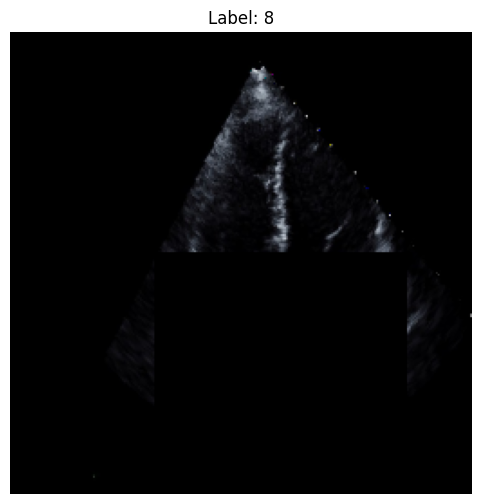

In [14]:
img, label = train_data[97]
visualize_normalized(img, label, avg_data_mean, avg_data_std)

### Create data loaders for the train and validation sets



In [15]:
train_loader = DataLoader(train_data, batch_size=32, drop_last=True, shuffle=True, pin_memory=True, num_workers= 1, persistent_workers=True)
#, pin_memory=True, num_workers= 8, persistent_workers=True)

val_loader = DataLoader(val_data, batch_size=32, drop_last=True, shuffle=False, pin_memory=True, num_workers= 1, persistent_workers=True)
# collate_fn=collate_fn)
# #pin_memory=True, num_workers= 8, persistent_workers=True)

test_loader = DataLoader(test_data, batch_size=32, drop_last=True, shuffle=False, pin_memory=True, num_workers= 1, persistent_workers=True)
#pin_memory=True, num_workers= 8, persistent_workers=True)


In [16]:
for i,l in train_loader:
    print(i.shape)
    break

torch.Size([32, 3, 256, 256])


### Define the neural network model architecture

In [17]:
class ChannelAttention(nn.Module):
    def __init__(self, in_planes, reduction=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)

        self.shared_MLP = nn.Sequential(
            nn.Conv2d(in_planes, in_planes // reduction, 1, bias=False),
            nn.ReLU(),
            nn.Conv2d(in_planes // reduction, in_planes, 1, bias=False)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.shared_MLP(self.avg_pool(x))
        max_out = self.shared_MLP(self.max_pool(x))
        out = avg_out + max_out
        return self.sigmoid(out)

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        assert kernel_size in (3, 7), 'kernel size must be 3 or 7'
        padding = 3 if kernel_size == 7 else 1

        self.conv = nn.Conv2d(2, 1, kernel_size, padding=padding, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x_cat = torch.cat([avg_out, max_out], dim=1)
        out = self.conv(x_cat)
        return self.sigmoid(out)

class CBAM(nn.Module):
    def __init__(self, channels, reduction=16, spatial_kernel=7):
        super(CBAM, self).__init__()
        self.ca = ChannelAttention(channels, reduction)
        self.sa = SpatialAttention(spatial_kernel)

    def forward(self, x):
        x = x * self.ca(x)
        x = x * self.sa(x)
        return x

class CNN_CBAM(nn.Module):
    def __init__(self, num_classes= 11):
        super(CNN_CBAM, self).__init__()

        base_model = convnext_base(weights='IMAGENET1K_V1')
        self.features = base_model.features
        feature_channels = 1024

        self.cbam = CBAM(channels=feature_channels)

        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Dropout(0.2),
            nn.Linear(feature_channels, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.cbam(x)
        x = self.classifier(x)
        return x
    
model = CNN_CBAM()

In [18]:
input1 = torch.rand(8, 3, 256, 256)
# input2 = torch.rand(8, 10, 3, 299, 299)
# model.eval()
print(model(input1))

tensor([[ 0.0277, -0.1364,  0.0925, -0.0280,  0.0841, -0.0867,  0.0346, -0.1113,
         -0.0469,  0.0180, -0.0212],
        [-0.0118, -0.0368,  0.1399, -0.0267,  0.1170, -0.1023,  0.0002, -0.0845,
         -0.0092,  0.0221, -0.0310],
        [ 0.0580, -0.0935,  0.1339,  0.0147,  0.0063, -0.0680,  0.0162, -0.0789,
         -0.0350,  0.0229,  0.0417],
        [-0.0072, -0.0180,  0.0684, -0.0206,  0.0733,  0.0035,  0.0036, -0.0392,
         -0.0659,  0.0059, -0.0331],
        [ 0.0465, -0.0498,  0.0513,  0.0283,  0.0826, -0.0710,  0.0807, -0.1582,
         -0.0128,  0.0466, -0.0667],
        [ 0.0165, -0.0242,  0.0363, -0.0408,  0.0712, -0.0569,  0.0343, -0.0858,
         -0.0452,  0.0691, -0.0268],
        [ 0.0352, -0.1107,  0.1139,  0.0054,  0.1367, -0.0124,  0.0259, -0.0350,
          0.0048,  0.0512, -0.0736],
        [-0.0465, -0.0376,  0.0879,  0.0108,  0.0728, -0.0139, -0.0231, -0.0428,
         -0.0303,  0.0213, -0.0218]], grad_fn=<AddmmBackward0>)


### Freeze initial layers of the model

In [19]:
def freeze_backbone(model):
    for param in model.features.parameters():
        param.requires_grad = False

In [20]:
def unfreeze_backbone(model):
    for param in model.features.parameters():
        param.requires_grad = True

### Define loss and optimizer

In [21]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = torch.device('cuda:0')
model.to(device)
if torch.cuda.device_count() > 1:
  print("Let's use", torch.cuda.device_count(), "GPUs!")
  model = nn.DataParallel(model)


# model.lstm.flatten_parameters() 
criterion = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5) ## changed from 0.001 to 0.0001 

def update_optimizer(model, new_lr):
    return torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=new_lr, weight_decay=1e-5)

print(device)

cuda


### Train the model

In [22]:
def evaluate(model, loader, device, mode='validation'):
  model.eval()
  total_correct = 0
  total_loss = 0
  # BATCH_SIZE = 64
  total = 0
  for i, (images, labels) in enumerate(loader):
    images = images.to(device)
    labels = labels.to(device)
    labels = labels.squeeze(1)
    with torch.no_grad():
      outputs = model(images)
      loss = criterion(outputs, labels)
      total += images.size(0)
      _, predictions = outputs.max(1)
      total_correct += (labels == predictions).sum()
      total_loss += loss.item() * images.size(0)
      # print('Valid \t',  predictions, labels, labels == predictions, total_correct, total, images.size(0), '\n')

  # print(total_correct, total, accuracy)
  loss = total_loss / total
  accuracy = total_correct / total
  print(f'{mode} epoch {epoch}: Loss({loss:6.4f}),  Accuracy ({accuracy:6.4f}))')
  return accuracy, loss



In [23]:
epochs = 13
backbone_freeze_epoch = 5
accs = []
losses = []
val_loss = 0.0
best_val_loss = float('inf')

freeze_backbone(model)
print("Backbone frozen.")

for epoch in range(epochs):
  model.train()
  total = 0
  running_loss = 0.
  running_corrects = 0
  # epochs_no_improve = 0
  if epoch == backbone_freeze_epoch:
    unfreeze_backbone(model)
    update_optimizer(model, new_lr=1e-5)
    print("Backbone unfrozen, optimizer updated.")

  for i, (images, labels) in enumerate(train_loader):
    images = images.to(device)
    labels = labels.to(device)
    optimizer.zero_grad()
    outputs = model(images)
    labels = labels.squeeze(1)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    total += images.size(0)
    _, predictions = outputs.max(1)
    running_loss += loss.item() * images.size(0)
    running_corrects += (predictions == labels).sum()

  epoch_loss = running_loss / total
  epoch_acc = running_corrects / total
  accs.append(epoch_acc)
  losses.append(epoch_loss)
  # loss = total_loss / total
  print(f'Train epoch {epoch}: Loss({epoch_loss:6.4f}, Accuracy ({epoch_acc:6.5f}) )')
  val_acc, val_loss = evaluate(model, val_loader, device, mode='valid')
  accs.append(val_acc)
  losses.append(val_loss)

  print('---')

  if(val_loss < best_val_loss):
    best_acc = val_acc
    best_val_loss = val_loss
    epochs_no_improve = 0
#     torch.save(model.state_dict(), (f'/home/student/shokoofa/Downloads/res_model{epoch}.pth'))
  else:
    epochs_no_improve += 1

  if epochs_no_improve > 2 and epoch > 7:
    print('no further improvement ', best_acc)
    break


Backbone frozen.
Train epoch 0: Loss(2.2833, Accuracy (0.22445) )
valid epoch 0: Loss(2.1688),  Accuracy (0.2305))
---
Train epoch 1: Loss(2.1421, Accuracy (0.28262) )
valid epoch 1: Loss(2.0949),  Accuracy (0.3164))
---
Train epoch 2: Loss(2.0809, Accuracy (0.32368) )
valid epoch 2: Loss(2.0395),  Accuracy (0.3340))
---
Train epoch 3: Loss(2.0401, Accuracy (0.34147) )
valid epoch 3: Loss(1.9934),  Accuracy (0.3477))
---
Train epoch 4: Loss(1.9950, Accuracy (0.36086) )
valid epoch 4: Loss(1.9511),  Accuracy (0.3447))
---
Backbone unfrozen, optimizer updated.
Train epoch 5: Loss(1.2046, Accuracy (0.57938) )
valid epoch 5: Loss(0.9462),  Accuracy (0.6562))
---
Train epoch 6: Loss(0.6333, Accuracy (0.79767) )
valid epoch 6: Loss(0.5843),  Accuracy (0.8105))
---
Train epoch 7: Loss(0.4653, Accuracy (0.84808) )
valid epoch 7: Loss(0.5637),  Accuracy (0.8262))
---
Train epoch 8: Loss(0.3725, Accuracy (0.88047) )
valid epoch 8: Loss(0.5921),  Accuracy (0.8262))
---
Train epoch 9: Loss(0.2997,

KeyboardInterrupt: 

In [22]:
# Best practice for saving models:
torch.save({
    'model_name': 'CNN_CBAM',
    'num_classes': 11,
    'state_dict': model.state_dict()
}, 'model_checkpoint-(CNN_CBAM)-acc0.828.pth')

# checkpoint = torch.load('model_checkpoint.pth')
# model = torchvision.models.resnet18(num_classes=checkpoint['num_classes'])
# model.load_state_dict(checkpoint['state_dict'])

#### Load a Pretrained Model

In [24]:
state_dict = torch.load('/home/shokoo/EchoView/video_class/singleframe/test3.pth', map_location='cpu')
new_state_dict = {k.replace('module.', ''): v for k, v in state_dict.items()}
model.load_state_dict(new_state_dict)
model.to(device)
val_acc, val_loss = evaluate(model, val_loader, device, mode='valid')

RuntimeError: Error(s) in loading state_dict for CNN_CBAM:
	Missing key(s) in state_dict: "features.0.0.weight", "features.0.0.bias", "features.0.1.weight", "features.0.1.bias", "features.1.0.layer_scale", "features.1.0.block.0.weight", "features.1.0.block.0.bias", "features.1.0.block.2.weight", "features.1.0.block.2.bias", "features.1.0.block.3.weight", "features.1.0.block.3.bias", "features.1.0.block.5.weight", "features.1.0.block.5.bias", "features.1.1.layer_scale", "features.1.1.block.0.weight", "features.1.1.block.0.bias", "features.1.1.block.2.weight", "features.1.1.block.2.bias", "features.1.1.block.3.weight", "features.1.1.block.3.bias", "features.1.1.block.5.weight", "features.1.1.block.5.bias", "features.1.2.layer_scale", "features.1.2.block.0.weight", "features.1.2.block.0.bias", "features.1.2.block.2.weight", "features.1.2.block.2.bias", "features.1.2.block.3.weight", "features.1.2.block.3.bias", "features.1.2.block.5.weight", "features.1.2.block.5.bias", "features.2.0.weight", "features.2.0.bias", "features.2.1.weight", "features.2.1.bias", "features.3.0.layer_scale", "features.3.0.block.0.weight", "features.3.0.block.0.bias", "features.3.0.block.2.weight", "features.3.0.block.2.bias", "features.3.0.block.3.weight", "features.3.0.block.3.bias", "features.3.0.block.5.weight", "features.3.0.block.5.bias", "features.3.1.layer_scale", "features.3.1.block.0.weight", "features.3.1.block.0.bias", "features.3.1.block.2.weight", "features.3.1.block.2.bias", "features.3.1.block.3.weight", "features.3.1.block.3.bias", "features.3.1.block.5.weight", "features.3.1.block.5.bias", "features.3.2.layer_scale", "features.3.2.block.0.weight", "features.3.2.block.0.bias", "features.3.2.block.2.weight", "features.3.2.block.2.bias", "features.3.2.block.3.weight", "features.3.2.block.3.bias", "features.3.2.block.5.weight", "features.3.2.block.5.bias", "features.4.0.weight", "features.4.0.bias", "features.4.1.weight", "features.4.1.bias", "features.5.0.layer_scale", "features.5.0.block.0.weight", "features.5.0.block.0.bias", "features.5.0.block.2.weight", "features.5.0.block.2.bias", "features.5.0.block.3.weight", "features.5.0.block.3.bias", "features.5.0.block.5.weight", "features.5.0.block.5.bias", "features.5.1.layer_scale", "features.5.1.block.0.weight", "features.5.1.block.0.bias", "features.5.1.block.2.weight", "features.5.1.block.2.bias", "features.5.1.block.3.weight", "features.5.1.block.3.bias", "features.5.1.block.5.weight", "features.5.1.block.5.bias", "features.5.2.layer_scale", "features.5.2.block.0.weight", "features.5.2.block.0.bias", "features.5.2.block.2.weight", "features.5.2.block.2.bias", "features.5.2.block.3.weight", "features.5.2.block.3.bias", "features.5.2.block.5.weight", "features.5.2.block.5.bias", "features.5.3.layer_scale", "features.5.3.block.0.weight", "features.5.3.block.0.bias", "features.5.3.block.2.weight", "features.5.3.block.2.bias", "features.5.3.block.3.weight", "features.5.3.block.3.bias", "features.5.3.block.5.weight", "features.5.3.block.5.bias", "features.5.4.layer_scale", "features.5.4.block.0.weight", "features.5.4.block.0.bias", "features.5.4.block.2.weight", "features.5.4.block.2.bias", "features.5.4.block.3.weight", "features.5.4.block.3.bias", "features.5.4.block.5.weight", "features.5.4.block.5.bias", "features.5.5.layer_scale", "features.5.5.block.0.weight", "features.5.5.block.0.bias", "features.5.5.block.2.weight", "features.5.5.block.2.bias", "features.5.5.block.3.weight", "features.5.5.block.3.bias", "features.5.5.block.5.weight", "features.5.5.block.5.bias", "features.5.6.layer_scale", "features.5.6.block.0.weight", "features.5.6.block.0.bias", "features.5.6.block.2.weight", "features.5.6.block.2.bias", "features.5.6.block.3.weight", "features.5.6.block.3.bias", "features.5.6.block.5.weight", "features.5.6.block.5.bias", "features.5.7.layer_scale", "features.5.7.block.0.weight", "features.5.7.block.0.bias", "features.5.7.block.2.weight", "features.5.7.block.2.bias", "features.5.7.block.3.weight", "features.5.7.block.3.bias", "features.5.7.block.5.weight", "features.5.7.block.5.bias", "features.5.8.layer_scale", "features.5.8.block.0.weight", "features.5.8.block.0.bias", "features.5.8.block.2.weight", "features.5.8.block.2.bias", "features.5.8.block.3.weight", "features.5.8.block.3.bias", "features.5.8.block.5.weight", "features.5.8.block.5.bias", "features.5.9.layer_scale", "features.5.9.block.0.weight", "features.5.9.block.0.bias", "features.5.9.block.2.weight", "features.5.9.block.2.bias", "features.5.9.block.3.weight", "features.5.9.block.3.bias", "features.5.9.block.5.weight", "features.5.9.block.5.bias", "features.5.10.layer_scale", "features.5.10.block.0.weight", "features.5.10.block.0.bias", "features.5.10.block.2.weight", "features.5.10.block.2.bias", "features.5.10.block.3.weight", "features.5.10.block.3.bias", "features.5.10.block.5.weight", "features.5.10.block.5.bias", "features.5.11.layer_scale", "features.5.11.block.0.weight", "features.5.11.block.0.bias", "features.5.11.block.2.weight", "features.5.11.block.2.bias", "features.5.11.block.3.weight", "features.5.11.block.3.bias", "features.5.11.block.5.weight", "features.5.11.block.5.bias", "features.5.12.layer_scale", "features.5.12.block.0.weight", "features.5.12.block.0.bias", "features.5.12.block.2.weight", "features.5.12.block.2.bias", "features.5.12.block.3.weight", "features.5.12.block.3.bias", "features.5.12.block.5.weight", "features.5.12.block.5.bias", "features.5.13.layer_scale", "features.5.13.block.0.weight", "features.5.13.block.0.bias", "features.5.13.block.2.weight", "features.5.13.block.2.bias", "features.5.13.block.3.weight", "features.5.13.block.3.bias", "features.5.13.block.5.weight", "features.5.13.block.5.bias", "features.5.14.layer_scale", "features.5.14.block.0.weight", "features.5.14.block.0.bias", "features.5.14.block.2.weight", "features.5.14.block.2.bias", "features.5.14.block.3.weight", "features.5.14.block.3.bias", "features.5.14.block.5.weight", "features.5.14.block.5.bias", "features.5.15.layer_scale", "features.5.15.block.0.weight", "features.5.15.block.0.bias", "features.5.15.block.2.weight", "features.5.15.block.2.bias", "features.5.15.block.3.weight", "features.5.15.block.3.bias", "features.5.15.block.5.weight", "features.5.15.block.5.bias", "features.5.16.layer_scale", "features.5.16.block.0.weight", "features.5.16.block.0.bias", "features.5.16.block.2.weight", "features.5.16.block.2.bias", "features.5.16.block.3.weight", "features.5.16.block.3.bias", "features.5.16.block.5.weight", "features.5.16.block.5.bias", "features.5.17.layer_scale", "features.5.17.block.0.weight", "features.5.17.block.0.bias", "features.5.17.block.2.weight", "features.5.17.block.2.bias", "features.5.17.block.3.weight", "features.5.17.block.3.bias", "features.5.17.block.5.weight", "features.5.17.block.5.bias", "features.5.18.layer_scale", "features.5.18.block.0.weight", "features.5.18.block.0.bias", "features.5.18.block.2.weight", "features.5.18.block.2.bias", "features.5.18.block.3.weight", "features.5.18.block.3.bias", "features.5.18.block.5.weight", "features.5.18.block.5.bias", "features.5.19.layer_scale", "features.5.19.block.0.weight", "features.5.19.block.0.bias", "features.5.19.block.2.weight", "features.5.19.block.2.bias", "features.5.19.block.3.weight", "features.5.19.block.3.bias", "features.5.19.block.5.weight", "features.5.19.block.5.bias", "features.5.20.layer_scale", "features.5.20.block.0.weight", "features.5.20.block.0.bias", "features.5.20.block.2.weight", "features.5.20.block.2.bias", "features.5.20.block.3.weight", "features.5.20.block.3.bias", "features.5.20.block.5.weight", "features.5.20.block.5.bias", "features.5.21.layer_scale", "features.5.21.block.0.weight", "features.5.21.block.0.bias", "features.5.21.block.2.weight", "features.5.21.block.2.bias", "features.5.21.block.3.weight", "features.5.21.block.3.bias", "features.5.21.block.5.weight", "features.5.21.block.5.bias", "features.5.22.layer_scale", "features.5.22.block.0.weight", "features.5.22.block.0.bias", "features.5.22.block.2.weight", "features.5.22.block.2.bias", "features.5.22.block.3.weight", "features.5.22.block.3.bias", "features.5.22.block.5.weight", "features.5.22.block.5.bias", "features.5.23.layer_scale", "features.5.23.block.0.weight", "features.5.23.block.0.bias", "features.5.23.block.2.weight", "features.5.23.block.2.bias", "features.5.23.block.3.weight", "features.5.23.block.3.bias", "features.5.23.block.5.weight", "features.5.23.block.5.bias", "features.5.24.layer_scale", "features.5.24.block.0.weight", "features.5.24.block.0.bias", "features.5.24.block.2.weight", "features.5.24.block.2.bias", "features.5.24.block.3.weight", "features.5.24.block.3.bias", "features.5.24.block.5.weight", "features.5.24.block.5.bias", "features.5.25.layer_scale", "features.5.25.block.0.weight", "features.5.25.block.0.bias", "features.5.25.block.2.weight", "features.5.25.block.2.bias", "features.5.25.block.3.weight", "features.5.25.block.3.bias", "features.5.25.block.5.weight", "features.5.25.block.5.bias", "features.5.26.layer_scale", "features.5.26.block.0.weight", "features.5.26.block.0.bias", "features.5.26.block.2.weight", "features.5.26.block.2.bias", "features.5.26.block.3.weight", "features.5.26.block.3.bias", "features.5.26.block.5.weight", "features.5.26.block.5.bias", "features.6.0.weight", "features.6.0.bias", "features.6.1.weight", "features.6.1.bias", "features.7.0.layer_scale", "features.7.0.block.0.weight", "features.7.0.block.0.bias", "features.7.0.block.2.weight", "features.7.0.block.2.bias", "features.7.0.block.3.weight", "features.7.0.block.3.bias", "features.7.0.block.5.weight", "features.7.0.block.5.bias", "features.7.1.layer_scale", "features.7.1.block.0.weight", "features.7.1.block.0.bias", "features.7.1.block.2.weight", "features.7.1.block.2.bias", "features.7.1.block.3.weight", "features.7.1.block.3.bias", "features.7.1.block.5.weight", "features.7.1.block.5.bias", "features.7.2.layer_scale", "features.7.2.block.0.weight", "features.7.2.block.0.bias", "features.7.2.block.2.weight", "features.7.2.block.2.bias", "features.7.2.block.3.weight", "features.7.2.block.3.bias", "features.7.2.block.5.weight", "features.7.2.block.5.bias", "cbam.ca.shared_MLP.0.weight", "cbam.ca.shared_MLP.2.weight", "cbam.sa.conv.weight", "classifier.3.weight", "classifier.3.bias". 
	Unexpected key(s) in state_dict: "conv.0.0.weight", "conv.0.1.weight", "conv.0.1.bias", "conv.0.1.running_mean", "conv.0.1.running_var", "conv.0.1.num_batches_tracked", "conv.1.0.block.0.0.weight", "conv.1.0.block.0.1.weight", "conv.1.0.block.0.1.bias", "conv.1.0.block.0.1.running_mean", "conv.1.0.block.0.1.running_var", "conv.1.0.block.0.1.num_batches_tracked", "conv.1.0.block.1.fc1.weight", "conv.1.0.block.1.fc1.bias", "conv.1.0.block.1.fc2.weight", "conv.1.0.block.1.fc2.bias", "conv.1.0.block.2.0.weight", "conv.1.0.block.2.1.weight", "conv.1.0.block.2.1.bias", "conv.1.0.block.2.1.running_mean", "conv.1.0.block.2.1.running_var", "conv.1.0.block.2.1.num_batches_tracked", "conv.1.1.block.0.0.weight", "conv.1.1.block.0.1.weight", "conv.1.1.block.0.1.bias", "conv.1.1.block.0.1.running_mean", "conv.1.1.block.0.1.running_var", "conv.1.1.block.0.1.num_batches_tracked", "conv.1.1.block.1.fc1.weight", "conv.1.1.block.1.fc1.bias", "conv.1.1.block.1.fc2.weight", "conv.1.1.block.1.fc2.bias", "conv.1.1.block.2.0.weight", "conv.1.1.block.2.1.weight", "conv.1.1.block.2.1.bias", "conv.1.1.block.2.1.running_mean", "conv.1.1.block.2.1.running_var", "conv.1.1.block.2.1.num_batches_tracked", "conv.2.0.block.0.0.weight", "conv.2.0.block.0.1.weight", "conv.2.0.block.0.1.bias", "conv.2.0.block.0.1.running_mean", "conv.2.0.block.0.1.running_var", "conv.2.0.block.0.1.num_batches_tracked", "conv.2.0.block.1.0.weight", "conv.2.0.block.1.1.weight", "conv.2.0.block.1.1.bias", "conv.2.0.block.1.1.running_mean", "conv.2.0.block.1.1.running_var", "conv.2.0.block.1.1.num_batches_tracked", "conv.2.0.block.2.fc1.weight", "conv.2.0.block.2.fc1.bias", "conv.2.0.block.2.fc2.weight", "conv.2.0.block.2.fc2.bias", "conv.2.0.block.3.0.weight", "conv.2.0.block.3.1.weight", "conv.2.0.block.3.1.bias", "conv.2.0.block.3.1.running_mean", "conv.2.0.block.3.1.running_var", "conv.2.0.block.3.1.num_batches_tracked", "conv.2.1.block.0.0.weight", "conv.2.1.block.0.1.weight", "conv.2.1.block.0.1.bias", "conv.2.1.block.0.1.running_mean", "conv.2.1.block.0.1.running_var", "conv.2.1.block.0.1.num_batches_tracked", "conv.2.1.block.1.0.weight", "conv.2.1.block.1.1.weight", "conv.2.1.block.1.1.bias", "conv.2.1.block.1.1.running_mean", "conv.2.1.block.1.1.running_var", "conv.2.1.block.1.1.num_batches_tracked", "conv.2.1.block.2.fc1.weight", "conv.2.1.block.2.fc1.bias", "conv.2.1.block.2.fc2.weight", "conv.2.1.block.2.fc2.bias", "conv.2.1.block.3.0.weight", "conv.2.1.block.3.1.weight", "conv.2.1.block.3.1.bias", "conv.2.1.block.3.1.running_mean", "conv.2.1.block.3.1.running_var", "conv.2.1.block.3.1.num_batches_tracked", "conv.2.2.block.0.0.weight", "conv.2.2.block.0.1.weight", "conv.2.2.block.0.1.bias", "conv.2.2.block.0.1.running_mean", "conv.2.2.block.0.1.running_var", "conv.2.2.block.0.1.num_batches_tracked", "conv.2.2.block.1.0.weight", "conv.2.2.block.1.1.weight", "conv.2.2.block.1.1.bias", "conv.2.2.block.1.1.running_mean", "conv.2.2.block.1.1.running_var", "conv.2.2.block.1.1.num_batches_tracked", "conv.2.2.block.2.fc1.weight", "conv.2.2.block.2.fc1.bias", "conv.2.2.block.2.fc2.weight", "conv.2.2.block.2.fc2.bias", "conv.2.2.block.3.0.weight", "conv.2.2.block.3.1.weight", "conv.2.2.block.3.1.bias", "conv.2.2.block.3.1.running_mean", "conv.2.2.block.3.1.running_var", "conv.2.2.block.3.1.num_batches_tracked", "conv.3.0.block.0.0.weight", "conv.3.0.block.0.1.weight", "conv.3.0.block.0.1.bias", "conv.3.0.block.0.1.running_mean", "conv.3.0.block.0.1.running_var", "conv.3.0.block.0.1.num_batches_tracked", "conv.3.0.block.1.0.weight", "conv.3.0.block.1.1.weight", "conv.3.0.block.1.1.bias", "conv.3.0.block.1.1.running_mean", "conv.3.0.block.1.1.running_var", "conv.3.0.block.1.1.num_batches_tracked", "conv.3.0.block.2.fc1.weight", "conv.3.0.block.2.fc1.bias", "conv.3.0.block.2.fc2.weight", "conv.3.0.block.2.fc2.bias", "conv.3.0.block.3.0.weight", "conv.3.0.block.3.1.weight", "conv.3.0.block.3.1.bias", "conv.3.0.block.3.1.running_mean", "conv.3.0.block.3.1.running_var", "conv.3.0.block.3.1.num_batches_tracked", "conv.3.1.block.0.0.weight", "conv.3.1.block.0.1.weight", "conv.3.1.block.0.1.bias", "conv.3.1.block.0.1.running_mean", "conv.3.1.block.0.1.running_var", "conv.3.1.block.0.1.num_batches_tracked", "conv.3.1.block.1.0.weight", "conv.3.1.block.1.1.weight", "conv.3.1.block.1.1.bias", "conv.3.1.block.1.1.running_mean", "conv.3.1.block.1.1.running_var", "conv.3.1.block.1.1.num_batches_tracked", "conv.3.1.block.2.fc1.weight", "conv.3.1.block.2.fc1.bias", "conv.3.1.block.2.fc2.weight", "conv.3.1.block.2.fc2.bias", "conv.3.1.block.3.0.weight", "conv.3.1.block.3.1.weight", "conv.3.1.block.3.1.bias", "conv.3.1.block.3.1.running_mean", "conv.3.1.block.3.1.running_var", "conv.3.1.block.3.1.num_batches_tracked", "conv.3.2.block.0.0.weight", "conv.3.2.block.0.1.weight", "conv.3.2.block.0.1.bias", "conv.3.2.block.0.1.running_mean", "conv.3.2.block.0.1.running_var", "conv.3.2.block.0.1.num_batches_tracked", "conv.3.2.block.1.0.weight", "conv.3.2.block.1.1.weight", "conv.3.2.block.1.1.bias", "conv.3.2.block.1.1.running_mean", "conv.3.2.block.1.1.running_var", "conv.3.2.block.1.1.num_batches_tracked", "conv.3.2.block.2.fc1.weight", "conv.3.2.block.2.fc1.bias", "conv.3.2.block.2.fc2.weight", "conv.3.2.block.2.fc2.bias", "conv.3.2.block.3.0.weight", "conv.3.2.block.3.1.weight", "conv.3.2.block.3.1.bias", "conv.3.2.block.3.1.running_mean", "conv.3.2.block.3.1.running_var", "conv.3.2.block.3.1.num_batches_tracked", "conv.4.0.block.0.0.weight", "conv.4.0.block.0.1.weight", "conv.4.0.block.0.1.bias", "conv.4.0.block.0.1.running_mean", "conv.4.0.block.0.1.running_var", "conv.4.0.block.0.1.num_batches_tracked", "conv.4.0.block.1.0.weight", "conv.4.0.block.1.1.weight", "conv.4.0.block.1.1.bias", "conv.4.0.block.1.1.running_mean", "conv.4.0.block.1.1.running_var", "conv.4.0.block.1.1.num_batches_tracked", "conv.4.0.block.2.fc1.weight", "conv.4.0.block.2.fc1.bias", "conv.4.0.block.2.fc2.weight", "conv.4.0.block.2.fc2.bias", "conv.4.0.block.3.0.weight", "conv.4.0.block.3.1.weight", "conv.4.0.block.3.1.bias", "conv.4.0.block.3.1.running_mean", "conv.4.0.block.3.1.running_var", "conv.4.0.block.3.1.num_batches_tracked", "conv.4.1.block.0.0.weight", "conv.4.1.block.0.1.weight", "conv.4.1.block.0.1.bias", "conv.4.1.block.0.1.running_mean", "conv.4.1.block.0.1.running_var", "conv.4.1.block.0.1.num_batches_tracked", "conv.4.1.block.1.0.weight", "conv.4.1.block.1.1.weight", "conv.4.1.block.1.1.bias", "conv.4.1.block.1.1.running_mean", "conv.4.1.block.1.1.running_var", "conv.4.1.block.1.1.num_batches_tracked", "conv.4.1.block.2.fc1.weight", "conv.4.1.block.2.fc1.bias", "conv.4.1.block.2.fc2.weight", "conv.4.1.block.2.fc2.bias", "conv.4.1.block.3.0.weight", "conv.4.1.block.3.1.weight", "conv.4.1.block.3.1.bias", "conv.4.1.block.3.1.running_mean", "conv.4.1.block.3.1.running_var", "conv.4.1.block.3.1.num_batches_tracked", "conv.4.2.block.0.0.weight", "conv.4.2.block.0.1.weight", "conv.4.2.block.0.1.bias", "conv.4.2.block.0.1.running_mean", "conv.4.2.block.0.1.running_var", "conv.4.2.block.0.1.num_batches_tracked", "conv.4.2.block.1.0.weight", "conv.4.2.block.1.1.weight", "conv.4.2.block.1.1.bias", "conv.4.2.block.1.1.running_mean", "conv.4.2.block.1.1.running_var", "conv.4.2.block.1.1.num_batches_tracked", "conv.4.2.block.2.fc1.weight", "conv.4.2.block.2.fc1.bias", "conv.4.2.block.2.fc2.weight", "conv.4.2.block.2.fc2.bias", "conv.4.2.block.3.0.weight", "conv.4.2.block.3.1.weight", "conv.4.2.block.3.1.bias", "conv.4.2.block.3.1.running_mean", "conv.4.2.block.3.1.running_var", "conv.4.2.block.3.1.num_batches_tracked", "conv.4.3.block.0.0.weight", "conv.4.3.block.0.1.weight", "conv.4.3.block.0.1.bias", "conv.4.3.block.0.1.running_mean", "conv.4.3.block.0.1.running_var", "conv.4.3.block.0.1.num_batches_tracked", "conv.4.3.block.1.0.weight", "conv.4.3.block.1.1.weight", "conv.4.3.block.1.1.bias", "conv.4.3.block.1.1.running_mean", "conv.4.3.block.1.1.running_var", "conv.4.3.block.1.1.num_batches_tracked", "conv.4.3.block.2.fc1.weight", "conv.4.3.block.2.fc1.bias", "conv.4.3.block.2.fc2.weight", "conv.4.3.block.2.fc2.bias", "conv.4.3.block.3.0.weight", "conv.4.3.block.3.1.weight", "conv.4.3.block.3.1.bias", "conv.4.3.block.3.1.running_mean", "conv.4.3.block.3.1.running_var", "conv.4.3.block.3.1.num_batches_tracked", "conv.5.0.block.0.0.weight", "conv.5.0.block.0.1.weight", "conv.5.0.block.0.1.bias", "conv.5.0.block.0.1.running_mean", "conv.5.0.block.0.1.running_var", "conv.5.0.block.0.1.num_batches_tracked", "conv.5.0.block.1.0.weight", "conv.5.0.block.1.1.weight", "conv.5.0.block.1.1.bias", "conv.5.0.block.1.1.running_mean", "conv.5.0.block.1.1.running_var", "conv.5.0.block.1.1.num_batches_tracked", "conv.5.0.block.2.fc1.weight", "conv.5.0.block.2.fc1.bias", "conv.5.0.block.2.fc2.weight", "conv.5.0.block.2.fc2.bias", "conv.5.0.block.3.0.weight", "conv.5.0.block.3.1.weight", "conv.5.0.block.3.1.bias", "conv.5.0.block.3.1.running_mean", "conv.5.0.block.3.1.running_var", "conv.5.0.block.3.1.num_batches_tracked", "conv.5.1.block.0.0.weight", "conv.5.1.block.0.1.weight", "conv.5.1.block.0.1.bias", "conv.5.1.block.0.1.running_mean", "conv.5.1.block.0.1.running_var", "conv.5.1.block.0.1.num_batches_tracked", "conv.5.1.block.1.0.weight", "conv.5.1.block.1.1.weight", "conv.5.1.block.1.1.bias", "conv.5.1.block.1.1.running_mean", "conv.5.1.block.1.1.running_var", "conv.5.1.block.1.1.num_batches_tracked", "conv.5.1.block.2.fc1.weight", "conv.5.1.block.2.fc1.bias", "conv.5.1.block.2.fc2.weight", "conv.5.1.block.2.fc2.bias", "conv.5.1.block.3.0.weight", "conv.5.1.block.3.1.weight", "conv.5.1.block.3.1.bias", "conv.5.1.block.3.1.running_mean", "conv.5.1.block.3.1.running_var", "conv.5.1.block.3.1.num_batches_tracked", "conv.5.2.block.0.0.weight", "conv.5.2.block.0.1.weight", "conv.5.2.block.0.1.bias", "conv.5.2.block.0.1.running_mean", "conv.5.2.block.0.1.running_var", "conv.5.2.block.0.1.num_batches_tracked", "conv.5.2.block.1.0.weight", "conv.5.2.block.1.1.weight", "conv.5.2.block.1.1.bias", "conv.5.2.block.1.1.running_mean", "conv.5.2.block.1.1.running_var", "conv.5.2.block.1.1.num_batches_tracked", "conv.5.2.block.2.fc1.weight", "conv.5.2.block.2.fc1.bias", "conv.5.2.block.2.fc2.weight", "conv.5.2.block.2.fc2.bias", "conv.5.2.block.3.0.weight", "conv.5.2.block.3.1.weight", "conv.5.2.block.3.1.bias", "conv.5.2.block.3.1.running_mean", "conv.5.2.block.3.1.running_var", "conv.5.2.block.3.1.num_batches_tracked", "conv.5.3.block.0.0.weight", "conv.5.3.block.0.1.weight", "conv.5.3.block.0.1.bias", "conv.5.3.block.0.1.running_mean", "conv.5.3.block.0.1.running_var", "conv.5.3.block.0.1.num_batches_tracked", "conv.5.3.block.1.0.weight", "conv.5.3.block.1.1.weight", "conv.5.3.block.1.1.bias", "conv.5.3.block.1.1.running_mean", "conv.5.3.block.1.1.running_var", "conv.5.3.block.1.1.num_batches_tracked", "conv.5.3.block.2.fc1.weight", "conv.5.3.block.2.fc1.bias", "conv.5.3.block.2.fc2.weight", "conv.5.3.block.2.fc2.bias", "conv.5.3.block.3.0.weight", "conv.5.3.block.3.1.weight", "conv.5.3.block.3.1.bias", "conv.5.3.block.3.1.running_mean", "conv.5.3.block.3.1.running_var", "conv.5.3.block.3.1.num_batches_tracked", "conv.6.0.block.0.0.weight", "conv.6.0.block.0.1.weight", "conv.6.0.block.0.1.bias", "conv.6.0.block.0.1.running_mean", "conv.6.0.block.0.1.running_var", "conv.6.0.block.0.1.num_batches_tracked", "conv.6.0.block.1.0.weight", "conv.6.0.block.1.1.weight", "conv.6.0.block.1.1.bias", "conv.6.0.block.1.1.running_mean", "conv.6.0.block.1.1.running_var", "conv.6.0.block.1.1.num_batches_tracked", "conv.6.0.block.2.fc1.weight", "conv.6.0.block.2.fc1.bias", "conv.6.0.block.2.fc2.weight", "conv.6.0.block.2.fc2.bias", "conv.6.0.block.3.0.weight", "conv.6.0.block.3.1.weight", "conv.6.0.block.3.1.bias", "conv.6.0.block.3.1.running_mean", "conv.6.0.block.3.1.running_var", "conv.6.0.block.3.1.num_batches_tracked", "conv.6.1.block.0.0.weight", "conv.6.1.block.0.1.weight", "conv.6.1.block.0.1.bias", "conv.6.1.block.0.1.running_mean", "conv.6.1.block.0.1.running_var", "conv.6.1.block.0.1.num_batches_tracked", "conv.6.1.block.1.0.weight", "conv.6.1.block.1.1.weight", "conv.6.1.block.1.1.bias", "conv.6.1.block.1.1.running_mean", "conv.6.1.block.1.1.running_var", "conv.6.1.block.1.1.num_batches_tracked", "conv.6.1.block.2.fc1.weight", "conv.6.1.block.2.fc1.bias", "conv.6.1.block.2.fc2.weight", "conv.6.1.block.2.fc2.bias", "conv.6.1.block.3.0.weight", "conv.6.1.block.3.1.weight", "conv.6.1.block.3.1.bias", "conv.6.1.block.3.1.running_mean", "conv.6.1.block.3.1.running_var", "conv.6.1.block.3.1.num_batches_tracked", "conv.6.2.block.0.0.weight", "conv.6.2.block.0.1.weight", "conv.6.2.block.0.1.bias", "conv.6.2.block.0.1.running_mean", "conv.6.2.block.0.1.running_var", "conv.6.2.block.0.1.num_batches_tracked", "conv.6.2.block.1.0.weight", "conv.6.2.block.1.1.weight", "conv.6.2.block.1.1.bias", "conv.6.2.block.1.1.running_mean", "conv.6.2.block.1.1.running_var", "conv.6.2.block.1.1.num_batches_tracked", "conv.6.2.block.2.fc1.weight", "conv.6.2.block.2.fc1.bias", "conv.6.2.block.2.fc2.weight", "conv.6.2.block.2.fc2.bias", "conv.6.2.block.3.0.weight", "conv.6.2.block.3.1.weight", "conv.6.2.block.3.1.bias", "conv.6.2.block.3.1.running_mean", "conv.6.2.block.3.1.running_var", "conv.6.2.block.3.1.num_batches_tracked", "conv.6.3.block.0.0.weight", "conv.6.3.block.0.1.weight", "conv.6.3.block.0.1.bias", "conv.6.3.block.0.1.running_mean", "conv.6.3.block.0.1.running_var", "conv.6.3.block.0.1.num_batches_tracked", "conv.6.3.block.1.0.weight", "conv.6.3.block.1.1.weight", "conv.6.3.block.1.1.bias", "conv.6.3.block.1.1.running_mean", "conv.6.3.block.1.1.running_var", "conv.6.3.block.1.1.num_batches_tracked", "conv.6.3.block.2.fc1.weight", "conv.6.3.block.2.fc1.bias", "conv.6.3.block.2.fc2.weight", "conv.6.3.block.2.fc2.bias", "conv.6.3.block.3.0.weight", "conv.6.3.block.3.1.weight", "conv.6.3.block.3.1.bias", "conv.6.3.block.3.1.running_mean", "conv.6.3.block.3.1.running_var", "conv.6.3.block.3.1.num_batches_tracked", "conv.6.4.block.0.0.weight", "conv.6.4.block.0.1.weight", "conv.6.4.block.0.1.bias", "conv.6.4.block.0.1.running_mean", "conv.6.4.block.0.1.running_var", "conv.6.4.block.0.1.num_batches_tracked", "conv.6.4.block.1.0.weight", "conv.6.4.block.1.1.weight", "conv.6.4.block.1.1.bias", "conv.6.4.block.1.1.running_mean", "conv.6.4.block.1.1.running_var", "conv.6.4.block.1.1.num_batches_tracked", "conv.6.4.block.2.fc1.weight", "conv.6.4.block.2.fc1.bias", "conv.6.4.block.2.fc2.weight", "conv.6.4.block.2.fc2.bias", "conv.6.4.block.3.0.weight", "conv.6.4.block.3.1.weight", "conv.6.4.block.3.1.bias", "conv.6.4.block.3.1.running_mean", "conv.6.4.block.3.1.running_var", "conv.6.4.block.3.1.num_batches_tracked", "conv.7.0.block.0.0.weight", "conv.7.0.block.0.1.weight", "conv.7.0.block.0.1.bias", "conv.7.0.block.0.1.running_mean", "conv.7.0.block.0.1.running_var", "conv.7.0.block.0.1.num_batches_tracked", "conv.7.0.block.1.0.weight", "conv.7.0.block.1.1.weight", "conv.7.0.block.1.1.bias", "conv.7.0.block.1.1.running_mean", "conv.7.0.block.1.1.running_var", "conv.7.0.block.1.1.num_batches_tracked", "conv.7.0.block.2.fc1.weight", "conv.7.0.block.2.fc1.bias", "conv.7.0.block.2.fc2.weight", "conv.7.0.block.2.fc2.bias", "conv.7.0.block.3.0.weight", "conv.7.0.block.3.1.weight", "conv.7.0.block.3.1.bias", "conv.7.0.block.3.1.running_mean", "conv.7.0.block.3.1.running_var", "conv.7.0.block.3.1.num_batches_tracked", "conv.7.1.block.0.0.weight", "conv.7.1.block.0.1.weight", "conv.7.1.block.0.1.bias", "conv.7.1.block.0.1.running_mean", "conv.7.1.block.0.1.running_var", "conv.7.1.block.0.1.num_batches_tracked", "conv.7.1.block.1.0.weight", "conv.7.1.block.1.1.weight", "conv.7.1.block.1.1.bias", "conv.7.1.block.1.1.running_mean", "conv.7.1.block.1.1.running_var", "conv.7.1.block.1.1.num_batches_tracked", "conv.7.1.block.2.fc1.weight", "conv.7.1.block.2.fc1.bias", "conv.7.1.block.2.fc2.weight", "conv.7.1.block.2.fc2.bias", "conv.7.1.block.3.0.weight", "conv.7.1.block.3.1.weight", "conv.7.1.block.3.1.bias", "conv.7.1.block.3.1.running_mean", "conv.7.1.block.3.1.running_var", "conv.7.1.block.3.1.num_batches_tracked", "conv.8.0.weight", "conv.8.1.weight", "conv.8.1.bias", "conv.8.1.running_mean", "conv.8.1.running_var", "conv.8.1.num_batches_tracked", "se_block.fc1.weight", "se_block.fc2.weight", "classifier_layer.3.weight", "classifier_layer.3.bias". 

In [24]:
def evaluate(model, loader, device, mode='Test'):
  model.eval()
  total_correct = 0
  total_loss = 0
  # BATCH_SIZE = 64
  total = 0
  for i, (images, labels) in enumerate(loader):
    images = images.to(device)
    labels = labels.to(device)
    labels = labels.squeeze(1)
    with torch.no_grad():
      outputs = model(images)
      loss = criterion(outputs, labels)
      total_loss += loss.item() * images.size(0)
      total += images.size(0) 
      _, predictions = outputs.max(1)
      total_correct += (labels == predictions).sum()

  # print(total_correct, total, accuracy)
  loss = total_loss / total
  accuracy = total_correct / total
  print(f'{mode} Loss({loss:6.4f}),  Accuracy ({accuracy:6.4f}))')
  return accuracy, loss

evaluate(model, loader= test_loader, device = device)


Test Loss(0.6209),  Accuracy (0.8423))


(tensor(0.8423, device='cuda:0'), 0.6209088338708336)

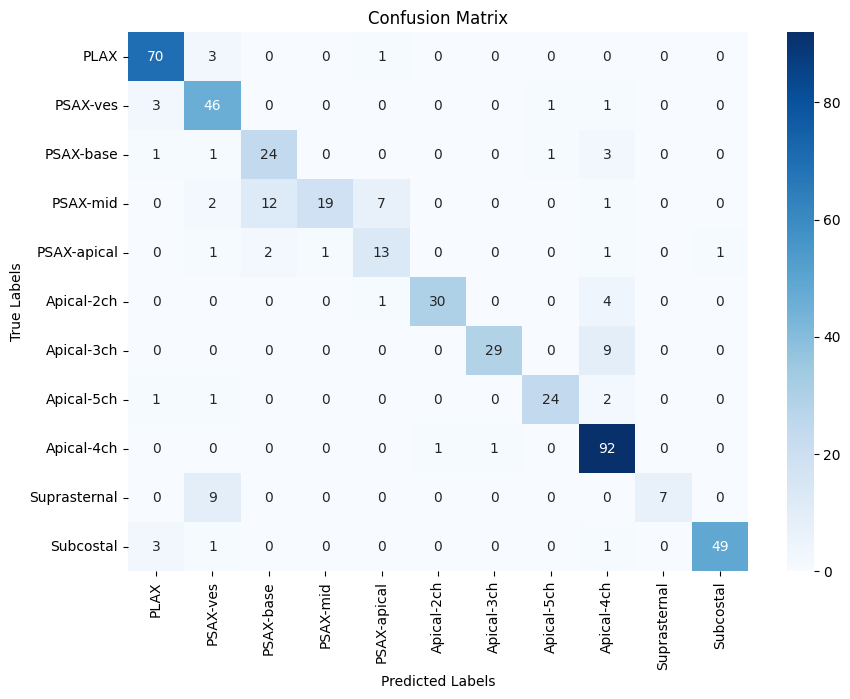

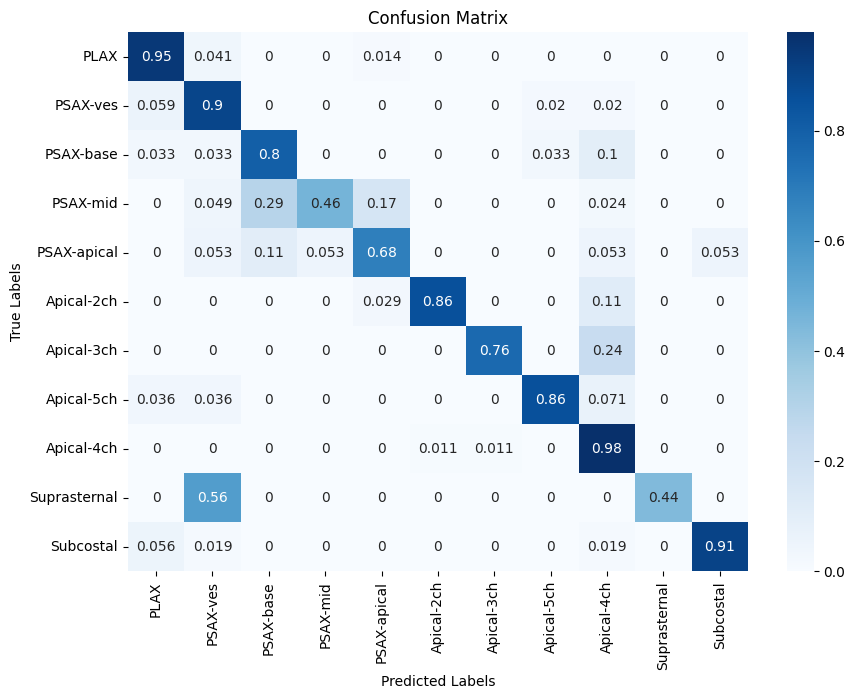

In [ ]:
true_labels, pred_labels = [], []

valid_labels = {'PLAX': 0, 'PSAX-ves' : 1, 'PSAX-base' : 2, 'PSAX-mid' : 3,
                              'PSAX-apical' : 4, 'Apical-2ch' : 5, 'Apical-3ch' : 6,
                              'Apical-5ch' : 7, 'Apical-4ch' : 8, 'Suprasternal' : 9, 'Subcostal' : 10
               }

labels_name = valid_labels.keys()
model.eval()
for i, (images, labels) in enumerate(test_loader):
    images = images.to(device)
    labels = labels.to(device)
    labels = labels.squeeze(1)
    
    with torch.no_grad():
        outputs = model(images)
        _, predictions = outputs.max(1)
        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(predictions.cpu().numpy())
        
cm = confusion_matrix(true_labels, pred_labels)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels_name, yticklabels=labels_name )
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

plt.figure(figsize=(10,7))
sns.heatmap(cm_normalized, annot=True, cmap='Blues', xticklabels=labels_name, yticklabels=labels_name )
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

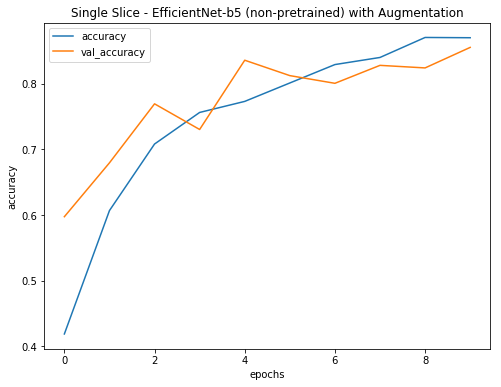

In [ ]:
from numpy.core.multiarray import zeros
import matplotlib.pyplot as plt
import numpy as np


# Generate sample data
x = [i for i in range(0,len(accs)//2)]
y = [accs[i].cpu() for i in range(0,len(accs),2)]
z = [accs[i].cpu() for i in range(1,len(accs),2)]


# Create a new figure and set the size
fig = plt.figure(figsize=(8, 6))

# Add a new subplot to the figure
ax = fig.add_subplot(1, 1, 1)

# Plot the line graph
ax.plot(x, y, label='accuracy')
ax.plot(x, z, label='val_accuracy')
ax.legend()
# Set the title and axis labels
ax.set_title('Single Slice - EfficientNet-b5 (non-pretrained) with Augmentation')
ax.set_xlabel('epochs')
ax.set_ylabel('accuracy')

# Display the plot
plt.show()


In [ ]:
# predictions == labels